# Heat equation with NGD
Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
\frac{\partial}{\partial t}u(t,x,y)-D \Delta u(t,x,y) = 0,\\
u(0, x, y)=\sin\pi x\sin\pi y
\end{cases}
$$

The solution is (TO CHECK) $u^\star(t,x) = e^{-2D\pi^2 t}\sin\pi x\sin\pi y$

In [1]:
import jinns

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/loss/_LossODE.py:41: UserWarning: Class `jinns.loss._LossODE.LossODE` has both an `__init__` method and a `__post_init__` method. This means that the `__post_init__` method will not be run!
The reason for this is that `__post_init__` is intended to be used with the automatically-generated `__init__` method provided by Python dataclasses, which are generated of the form:
```
def __init__(self, field1, field2)
    self.field1 = field1
    self.field2 = field2
    self.__post_init__()
```
and as such a user-provided `__init__` overrides both the setting of fields, and the calling of `__post_init__`.
The above is how Python dataclasses work, and has nothing to do with Equinox!
If you are using `__post_init__` to check that certain invariants hold, then consider using `__check_init__` instead. This is an Equinox-specific extension that is always ran. See here for more details: https://docs.kidger.site/equinox/api/module/advanced_fields/#checkin

In [2]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

In [3]:
n = 10000
ni = n
nb = n
domain_batch_size = 400
initial_batch_size = domain_batch_size
border_batch_size = domain_batch_size // 4
dim = 2
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin, xmin),
    max_pts=(xmax, xmax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [4]:
eqx_list = (
    (eqx.nn.Linear, 3, 25),  # 3 = t + x (2D)
    (jax.nn.tanh,),
    (eqx.nn.Linear, 25, 25),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 25, 1),
)

key, subkey = random.split(key)
u, init_sol_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="PDENonStatio"
)

In [5]:
D = jnp.array(0.2)
init_params = jinns.parameters.Params(
    nn_params=init_sol_nn_params,
    eq_params={"D": D},
)

In [6]:
from jinns.loss import PDENonStatio


class HeatEquation(PDENonStatio):
    def equation(self, t_x, u, params):
        u_t_x = lambda t_x: u(t_x, params).squeeze()
        u_dt = jax.grad(u_t_x)(t_x)[0:1]
        lap = jinns.loss.laplacian_rev(t_x, u, params, eq_type="PDENonStatio")
        return u_dt - params.eq_params.D * lap


dyn_loss_heat = HeatEquation()

In [7]:
boundary_condition = jinns.loss.Dirichlet()

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=jnp.array(1.0),
    initial_condition=jnp.array(1.0),
    boundary_loss=None if boundary_condition is None else jnp.array(1.0),
)

In [8]:
def u0(x):
    # mu_0 = jnp.zeros((dim,))
    # cov_0 = 0.3 * jnp.eye(dim)
    # return jax.scipy.stats.multivariate_normal.pdf(x, mean=mu_0, cov=cov_0)
    return jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])

In [9]:
u0(jnp.ones(2))

Array(7.642742e-15, dtype=float32)

In [10]:
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dyn_loss_heat,
    initial_condition_fun=u0,
    boundary_condition=boundary_condition,
    params=init_params,
)

In [11]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, colloc_batch = train_data.get_batch()

std_grad = losses_and_grad(init_params, batch=colloc_batch)[1]

# True solution

In [12]:
def u_true(t_x):
    t, x = t_x[0], t_x[1:]
    return jnp.exp(-2 * D * t * jnp.pi**2) * u0(x)


# Sanity check of true u formula
txy = jax.random.uniform(key, shape=(100, 3))
true_res = vmap(dyn_loss_heat.equation, (0, None, None))(
    txy, lambda tx, p: u_true(tx), init_params
)
assert jnp.allclose(true_res, jnp.zeros(100), atol=1e-6)

Text(0.5, 0.98, 'Ground truth : $u^\\star(t, x)$')

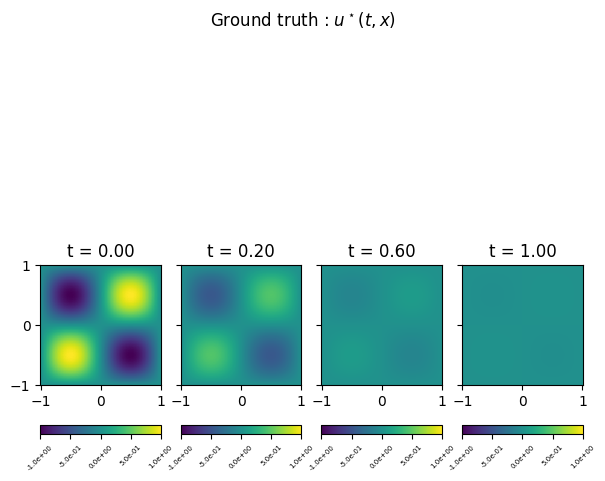

In [13]:
figsize = (7, 7)
nx = 200
val_xydata = (jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx))
times = [0, 0.2, 0.6, 1]  # times in the rescaled time scale

jinns.plot.plot2d(
    u_true,
    xy_data=val_xydata,
    times=times,
    cmap="viridis",
    figsize=figsize,
    vmin_vmax=(-1, 1),
    title=r"Ground truth : $u^\star(t, x)$",
)
plt.suptitle(r"Ground truth : $u^\star(t, x)$")

# Run natural gradient descent

In [14]:
import optax
from jinns.optimizers import vanilla_ngd

n_iter = 100
ngd_optim = optax.chain(
    optax.sgd(learning_rate=1.0),
    optax.scale_by_backtracking_linesearch(max_backtracking_steps=15, verbose=True),
)
tx = vanilla_ngd(ngd_optim)  # use jinns custom wrapper to tell `solve` to use ngd

In [15]:
ngd_params = init_params

In [16]:
key, subkey = random.split(key, 2)
(
    ngd_params,
    total_loss_list,
    loss_by_term_dict,
    train_data,
    loss,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=ngd_params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=n_iter // 10,
)

Initialization time: 4.862246036529541

Compilation took
 9.402475595474243 

[train] Iteration 0: loss value = 0.14124885201454163
[train] Iteration 10: loss value = 0.053743116557598114
[train] Iteration 20: loss value = 0.00027625163784250617
[train] Iteration 30: loss value = 5.611669985228218e-05
[train] Iteration 40: loss value = 3.360217306180857e-05
[train] Iteration 50: loss value = 6.999865036050323e-06
[train] Iteration 60: loss value = 1.1537770660652313e-05
[train] Iteration 70: loss value = 1.7132102584582753e-05
[train] Iteration 80: loss value = 8.95385819603689e-05
[train] Iteration 90: loss value = 1.0907870091614313e-05

Stopping main optimization loop, cause: max iteration is reached

Training took
 0.714296817779541 


Final iteration 100: train loss value = 1.0777841453091241e-05


In [17]:
assert ngd_params.eq_params.D == D  # should not move

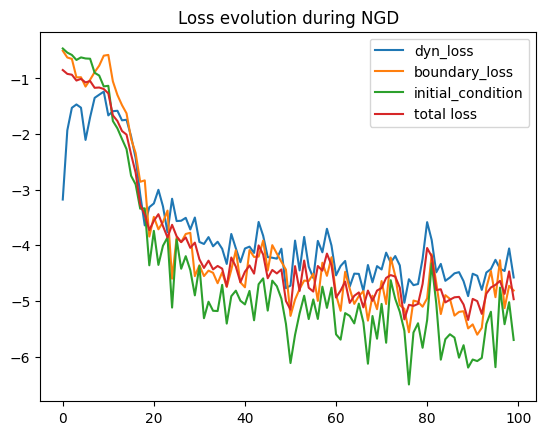

In [18]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.title("Loss evolution during NGD")
plt.show()

In [19]:
def plot_pinn(u, est_params, val_xydata, times, figsize, plot_residuals=False):
    u_est = lambda t_x: u(t_x, est_params)[0]

    jinns.plot.plot2d(
        u_est,
        xy_data=val_xydata,
        times=times,
        cmap="viridis",
        figsize=figsize,
        vmin_vmax=(-1, 1),
    )
    plt.suptitle("PINN : u(t, x)")

    # Plot difference
    jinns.plot.plot2d(
        lambda tx: jnp.abs(u_true(tx) - u_est(tx)),
        xy_data=val_xydata,
        times=times,
        cmap="viridis",
        figsize=figsize,
    )
    plt.suptitle(r"Absolute difference with ground truth")

    if plot_residuals:
        # Plot the equation residuals
        print("Equation residuals : N[u](t, x)")
        jinns.plot.plot2d(
            lambda tx: dyn_loss_heat.equation(tx, u, est_params),
            xy_data=val_xydata,
            times=times,
            cmap="viridis",
            figsize=(10, 10),
            # vmin_vmax=(-1, 1),
        )

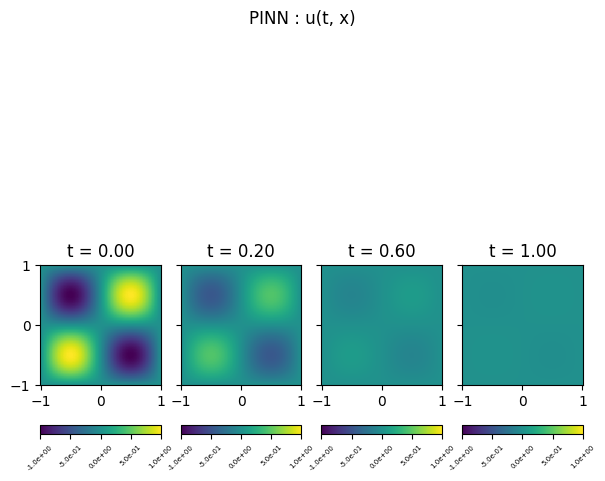

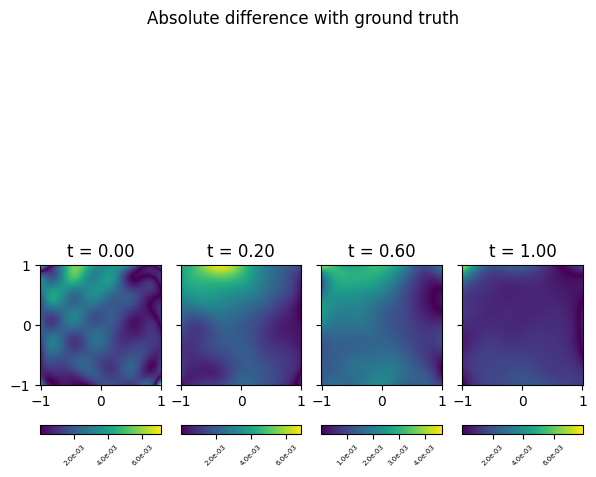

In [20]:
plot_pinn(u, ngd_params, val_xydata, times, figsize, plot_residuals=False)

# Comparison with vanilla GD (using Adam + more iterations)

In [21]:
n_iter = 10000
tx = optax.adam(learning_rate=1e-3)

In [22]:
sgd_params = init_params

In [23]:
key, subkey = random.split(key, 2)
(
    sgd_params,
    total_loss_list,
    loss_by_term_dict,
    train_data,
    loss,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=sgd_params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=n_iter // 10,
)

Initialization time: 5.010693788528442

Compilation took
 9.172169923782349 

[train] Iteration 0: loss value = 0.6618133783340454
[train] Iteration 1000: loss value = 0.14155662059783936
[train] Iteration 2000: loss value = 0.06636720150709152
[train] Iteration 3000: loss value = 0.03066803142428398
[train] Iteration 4000: loss value = 0.02080516703426838
[train] Iteration 5000: loss value = 0.01638423278927803
[train] Iteration 6000: loss value = 0.013112127780914307
[train] Iteration 7000: loss value = 0.01158623956143856
[train] Iteration 8000: loss value = 0.008564000017940998
[train] Iteration 9000: loss value = 0.00885195005685091

Stopping main optimization loop, cause: max iteration is reached

Training took
 8.425480604171753 


Final iteration 10000: train loss value = 0.009489231742918491


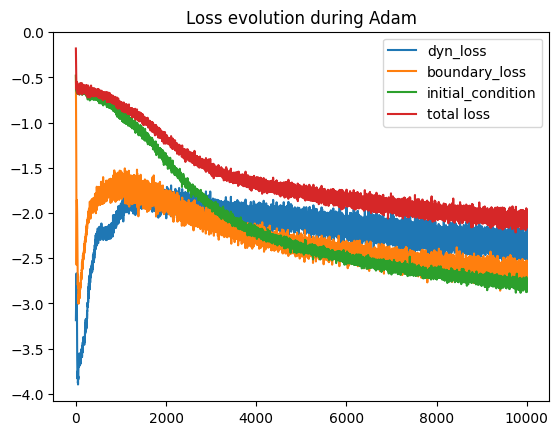

In [24]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.title("Loss evolution during Adam")
plt.show()

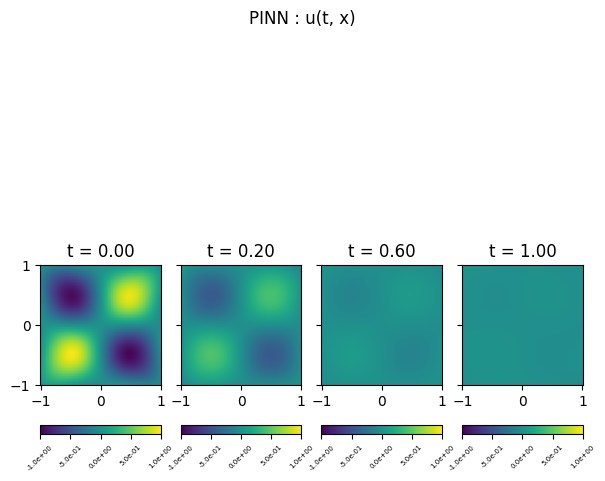

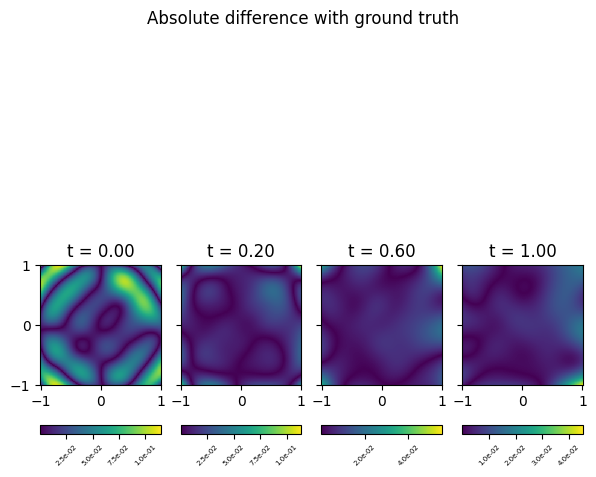

In [25]:
plot_pinn(u, sgd_params, val_xydata, times, figsize, plot_residuals=False)